# **Identifying Key Entities in Recipe Data**

### Name: Suraj Bhadra

### Cohort: C75


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

In [11]:
!pip install spacy
!python -m spacy download en_core_web_sm

   ---------------------------------------- 0.0/14.2 MB ? eta -:--:--
   -------- ------------------------------- 3.1/14.2 MB 16.8 MB/s eta 0:00:01
   ------------- -------------------------- 4.7/14.2 MB 13.0 MB/s eta 0:00:01
   --------------- ------------------------ 5.5/14.2 MB 9.9 MB/s eta 0:00:01
   ---------------- ----------------------- 5.8/14.2 MB 8.0 MB/s eta 0:00:02
   ----------------- ---------------------- 6.3/14.2 MB 6.2 MB/s eta 0:00:02
   ------------------- -------------------- 6.8/14.2 MB 5.7 MB/s eta 0:00:02
   --------------------- ------------------ 7.6/14.2 MB 5.3 MB/s eta 0:00:02
   ------------------------ --------------- 8.7/14.2 MB 5.2 MB/s eta 0:00:02
   --------------------------- ------------ 9.7/14.2 MB 5.2 MB/s eta 0:00:01
   ------------------------------ --------- 11.0/14.2 MB 5.3 MB/s eta 0:00:01
   ---------------------------------- ----- 12.3/14.2 MB 5.4 MB/s eta 0:00:01
   ---------------------------------------  14.2/14.2 MB 5.6 MB/s eta 0:00:01
 

#### **1.2** Import necessary libraries

In [13]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [209]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [211]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [216]:
# define a function to load json file to a dataframe

def load_json_to_dataframe(filepath: str) -> pd.DataFrame:
    """
    Load the ingredient_and_quantity.json file and convert it into a pandas DataFrame.

    Parameters:
    -----------
    filepath : str
        Full path to the ingredient_and_quantity.json file.

    Returns:
    --------
    pd.DataFrame
        DataFrame created from the JSON file. Expects keys like 'input' and 'pos'.
    """
    # Open and read JSON file
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    # Convert JSON list/dict to DataFrame
    df = pd.DataFrame(data)
    
    # Validate essential columns
    required_cols = ['input', 'pos']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
            
    return df


##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [219]:
# read the json file by giving the file path and create a dataframe

# File path to your JSON file
filepath = "ingredient_and_quantity.json"

# Load the DataFrame
df = load_json_to_dataframe(filepath)


##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [222]:
# display first five rows of the dataframe - df
print("First five rows:")
df.head()

First five rows:


,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [224]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [226]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


In [228]:
df.describe(include='all')

,input,pos
count,285,285
unique,285,284
top,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
freq,1,2


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [232]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df["input_tokens"] = df["input"].apply(lambda x: x.split())

# Tokenize POS
df["pos_tokens"] = df["pos"].apply(lambda x: x.split())

In [234]:
# display first five rows of the dataframe - df
df.head()

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [237]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df["input_length"] = df["input_tokens"].apply(len)
df["pos_length"] = df["pos_tokens"].apply(len)

In [239]:
# check for the equality of input_length and pos_length in the dataframe
unequal_rows = df[df["input_length"] != df["pos_length"]]
unequal_rows

,input,pos,input_tokens,pos_tokens,input_length,pos_length
17,2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt,quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,14
27,1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce,quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Baguette, sliced, 1, 1/2, tablespoon, Butter, 1/2, Garlic, minced, cup, Spinach, Leaves, Palak, Red, Bell, pepper, Capsicum, Tomato, finely, chopped, Onion, Black, powder, Italian, seasoning, teaspoon, Fresh, cream, Cheddar, cheese, grated, Salt, Roasted, tomato, pasta, sauce]","[quantity, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",37,36
79,1/2 cup Poha Flattened rice 2 tablespoons Rice flour 2 1/2 liter Milk 1 Nolen Gur or brown sugar Cardamom Elaichi Pods/Seeds 8-10 Mixed nuts almonds/cashews tablespoon Raisins pinch Saffron strands and a little more for garnish Salt,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1/2, cup, Poha, Flattened, rice, 2, tablespoons, Rice, flour, 2, 1/2, liter, Milk, 1, Nolen, Gur, or, brown, sugar, Cardamom, Elaichi, Pods/Seeds, 8-10, Mixed, nuts, almonds/cashews, tablespoon, Raisins, pinch, Saffron, strands, and, a, little, more, for, garnish, Salt]","[quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",38,37
164,1/2 cup All Purpose Flour Maida Whole Wheat 1/4 Hung Curd Greek Yogurt 250 grams Chicken minced 1 Spinach Leaves Palak finely chopped Onion 4 cloves Garlic Tomatoes tablespoon Cumin powder Jeera Coriander Powder Dhania 1 1/2 teaspoon Paprika Black pepper 3 sprig Mint Pudina 10 Spring Bulb & Greens 100 Feta Cheese crumbled,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [242]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    """
    Extract and print all unique POS labels from the 'pos_tokens' column.
    Returns a sorted list of unique labels.
    """
    # Flatten all POS tokens into a single list
    all_labels = set(label for row in df["pos_tokens"] for label in row)

    # Convert to sorted list
    unique_pos = sorted(all_labels)

    # Print the labels
    print("Unique POS Labels in the Recipe Dataset:")
    for label in unique_pos:
        print(label)

    return unique_pos

In [244]:
unique_pos_tags = unique_labels(df)

Unique POS Labels in the Recipe Dataset:
ingredient
quantity
unit


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [247]:
unequal_rows.index.tolist()

[17, 27, 79, 164, 207]

<font color = red>[write your answer]</font> <br>

In [250]:
invalid_indexes = [17, 27, 79, 164, 207]

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [253]:
# drop the irrelevant recipe data
df_cleaned = df.drop(index=invalid_indexes).reset_index(drop=True)

# display the cleaned dataframe
df_cleaned.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [256]:
# update the input and pos length in input_length and pos_length
# Recalculate lengths after cleaning
df_cleaned["input_length"] = df_cleaned["input_tokens"].apply(len)
df_cleaned["pos_length"] = df_cleaned["pos_tokens"].apply(len)

# Display to verify
df_cleaned[["input", "input_length", "pos_length"]].head()

,input,input_length,pos_length
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,31,31
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,34,34
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,37,37
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,46,46
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,21,21


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [259]:
# validate the input length and pos length as input_length and pos_length
df_cleaned[df_cleaned["input_length"] != df_cleaned["pos_length"]]

,input,pos,input_tokens,pos_tokens,input_length,pos_length


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [264]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(
    df_cleaned,
    test_size=0.30,      # 30% for validation
    random_state=42,     # ensures reproducibility
    shuffle=True
)

# display sizes
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))

Training set size: 196
Validation set size: 84


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [267]:
# print the first five rows of train_df
train_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length
175,250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
55,200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]",41,41
109,500 grams Cabbage Patta Gobi Muttaikose 1 teaspoon Mustard seeds 1-1/2 White Urad Dal Split sprig Curry leaves Green Chilli 1/4 cup Fresh coconut Salt,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",25,25
213,500 grams Fresh Figs 1/4 cup Lemon juice 1 teaspoon zest 2 Red Chilli flakes 1/2 Honey Brown Sugar (Demerara Sugar),quantity unit ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, qua

In [269]:
# print the first five rows of the val_df
val_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length
33,1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi,quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,15
108,1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi Pods/Seeds Cumin Jeera,quantity ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",56,56
240,1 tablespoon Sunflower Oil 3 Potato Aloo Ginger paste Green Chilli chopped 1-1/12 tablespoons Sesame seeds Til teaspoon Red powder Cumin Jeera Coriander Powder Dhania 1/2 Garam masala 2 Sweet Chutney Date Tamarind Leaves few,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",35,35
259,1 cup green peas gram flour 1/2 cheese tsp ginger 2 chillies turmeric powder cumin teaspoon salt oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient unit ingredient quantity ingredient i

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [272]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df["input_tokens"].tolist()
y_train = train_df["pos_tokens"].tolist()

X_val = val_df["input_tokens"].tolist()
y_val = val_df["pos_tokens"].tolist()

In [274]:
# validate the shape of training and validation samples
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_val:", len(X_val))
print("Length of y_val:", len(y_val))

Length of X_train: 196
Length of y_train: 196
Length of X_val: 84
Length of y_val: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [277]:
# Display the number of unique labels present in y_train
unique_y_train_labels = set(label for seq in y_train for label in seq)

print("Number of unique labels in y_train:", len(unique_y_train_labels))
print("Unique labels:", unique_y_train_labels)

Number of unique labels in y_train: 3
Unique labels: {'ingredient', 'quantity', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [281]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    """
    Flattens a nested list (list of lists) into a single list.
    Example: [['add','salt'], ['mix','well']] -> ['add','salt','mix','well']
    """
    flat = [item for sublist in nested_list for item in sublist]
    return flat

In [283]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [286]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
def extract_and_validate_tokens(df, dataset_name):
    """
    Flatten input_tokens and pos_tokens,
    validate lengths, and display the first 10 tokens.
    """
    # call the flatten_list and apply it on input_tokens and pos_tokens
    flat_input_tokens = flatten_list(df["input_tokens"].tolist())
    flat_pos_tokens = flatten_list(df["pos_tokens"].tolist())

    # validate their length and display first 10 records having input and pos tokens

    # validate their length
    print(f"Dataset: {dataset_name}")
    print("Length of flattened input_tokens:", len(flat_input_tokens))
    print("Length of flattened pos_tokens:", len(flat_pos_tokens))
    
    if len(flat_input_tokens) == len(flat_pos_tokens):
        print("✔ Validation Passed: Both flattened lists have equal length.\n")
    else:
        print("✘ Validation Failed: Length mismatch detected.\n")
    
    # display first 10 records having input and pos tokens
    print("First 10 input tokens:", flat_input_tokens[:10])
    print("First 10 POS tokens:   ", flat_pos_tokens[:10])
    
    return flat_input_tokens, flat_pos_tokens

In [288]:
# extract the tokens and its pos tags
tokens, pos_tags = extract_and_validate_tokens(train_df, "Training")

Dataset: Training
Length of flattened input_tokens: 7114
Length of flattened pos_tokens: 7114
✔ Validation Passed: Both flattened lists have equal length.

First 10 input tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 POS tokens:    ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [291]:
unique_pos_tags = set(pos_tags)
unique_pos_tags

{'ingredient', 'quantity', 'unit'}

In [293]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):
    """
    Categorise flattened tokens into ingredients, units and quantities.
    - tokens:    list of token strings
    - pos_tags:  list of POS/NER tag strings, same length as tokens

    Returns: ingredients, units, quantities (each a list)
    If no matching labels are found, returns three empty lists.
    """

    if len(tokens) != len(pos_tags):
        raise ValueError("tokens and pos_tags must be same length")

    # keywords to match (all lowercase)
    ingredient_keys = {"ingredient", "ing", "b-ingredient", "i-ingredient", "b-ing", "i-ing"}
    unit_keys       = {"unit", "u", "b-unit", "i-unit"}
    quantity_keys   = {"quantity", "qty", "q", "num", "number", "quantity.1", "b-quantity", "i-quantity", "b-q", "i-q"}

    # helper to test tag membership by substring matching
    def tag_matches(tag, keys):
        t = str(tag).lower()
        # direct membership or substring (handles prefixes like B- or I-)
        if t in keys:
            return True
        for k in keys:
            if k in t:
                return True
        return False

    # quick presence check: if none of the required label keywords present -> return empties
    flattened_tagset = set(str(t).lower() for t in pos_tags)
    present = any(any(k in tt for k in (ingredient_keys | unit_keys | quantity_keys)) for tt in flattened_tagset)
    if not present:
        # no matching labels found
        return [], [], []

    ingredients = []
    units = []
    quantities = []

    for tok, tag in zip(tokens, pos_tags):
        t = str(tag).lower()

        if tag_matches(t, ingredient_keys):
            ingredients.append(tok)
        elif tag_matches(t, unit_keys):
            units.append(tok)
        elif tag_matches(t, quantity_keys):
            quantities.append(tok)
        # else: ignore tokens that are not ingredient/unit/quantity

    # summary print
    print(f"Found {len(ingredients)} ingredient tokens, {len(units)} unit tokens, {len(quantities)} quantity tokens.")
    return ingredients, units, quantities

In [295]:
#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(tokens, pos_tags)

# Display sample outputs
print("Ingredients (sample):", ingredients[:20])
print("Units (sample):      ", units[:20])
print("Quantities (sample): ", quantities[:20])

Found 5323 ingredient tokens, 1791 unit tokens, 0 quantity tokens.
Ingredients (sample): ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely', 'Cumin', 'seeds', 'asafoetida', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red']
Units (sample):       ['250', 'grams', '1', 'teaspoon', '2', '1/2', '1/4', 'Teaspoon', 'cup', '200', 'grams', '2', '1', 'tablespoon', 'teaspoon', '1/2', '500', 'grams', '1', 'teaspoon']
Quantities (sample):  []


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [298]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter
from typing import List, Tuple

def get_top_frequent_items(item_list: List[str], pos_label: str, dataset_name: str, top_n: int = 10) -> List[Tuple[str, int]]:
    """
    Returns the top `top_n` most frequent items from `item_list`.
    
    Parameters
    ----------
    item_list : List[str]
        List of tokens (e.g., ingredients or units).
    pos_label : str
        A label string to display in the output (e.g., "Ingredient", "Unit").
    dataset_name : str
        Name of the dataset (e.g., "Training" or "Validation") for display.
    top_n : int
        Number of top items to return (default 10).
    
    Returns
    -------
    List[Tuple[str,int]]
        List of (item, count) tuples ordered by descending frequency.
    """
    if not item_list:
        print(f"[{dataset_name} | {pos_label}] No items found.")
        return []
    
    counter = Counter(item_list)
    top_items = counter.most_common(top_n)
    
    print(f"[{dataset_name} | {pos_label}] Top {len(top_items)} items:")
    for i, (item, cnt) in enumerate(top_items, start=1):
        print(f"{i:2d}. {item!r} — {cnt}")
    
    return top_items

In [300]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients, pos_label="Ingredient", dataset_name=dataset_name, top_n=10)

[Training | Ingredient] Top 10 items:
 1. 'powder' — 129
 2. 'Salt' — 102
 3. 'seeds' — 89
 4. 'Green' — 85
 5. 'chopped' — 84
 6. 'Oil' — 83
 7. 'Red' — 81
 8. 'Chilli' — 77
 9. 'Coriander' — 71
10. 'Sunflower' — 65


In [302]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, pos_label="Unit", dataset_name=dataset_name, top_n=10)

[Training | Unit] Top 10 items:
 1. '1' — 191
 2. 'teaspoon' — 162
 3. '2' — 156
 4. '1/2' — 145
 5. 'cup' — 136
 6. '1/4' — 105
 7. 'tablespoon' — 99
 8. '3' — 65
 9. 'grams' — 63
10. 'tablespoons' — 61


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [306]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, label, dataset_name):
    """
    Plot a bar graph for top frequent items.

    Parameters:
    -----------
    top_items : list of (item, count)
        Output from get_top_frequent_items()
    label : str
        "Ingredient" or "Unit"
    dataset_name : str
        Name of dataset, e.g., "Training"
    """

    if not top_items:
        print(f"No items available to plot for {label} in {dataset_name}.")
        return

     # Separate names and counts
    items = [item for item, count in top_items]
    counts = [count for item, count in top_items]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(items, counts)

    # Rotate X-axis labels
    plt.xticks(rotation=45, ha='right')

    # Axis labels and title
    plt.xlabel(f"{label} Items")
    plt.ylabel("Frequency")
    plt.title(f"Top 10 Most Frequent {label}s – {dataset_name} Dataset")

    #Data labels
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            str(height),
            ha='center',
            va='bottom',
            fontsize=9
        )
        
    plt.tight_layout()
    plt.show()
        

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



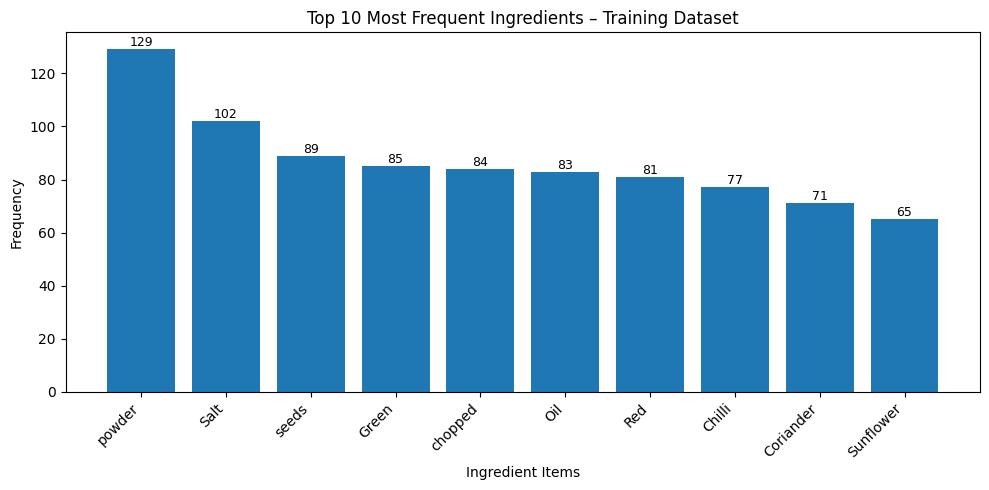

In [309]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, label="Ingredient", dataset_name="Training")

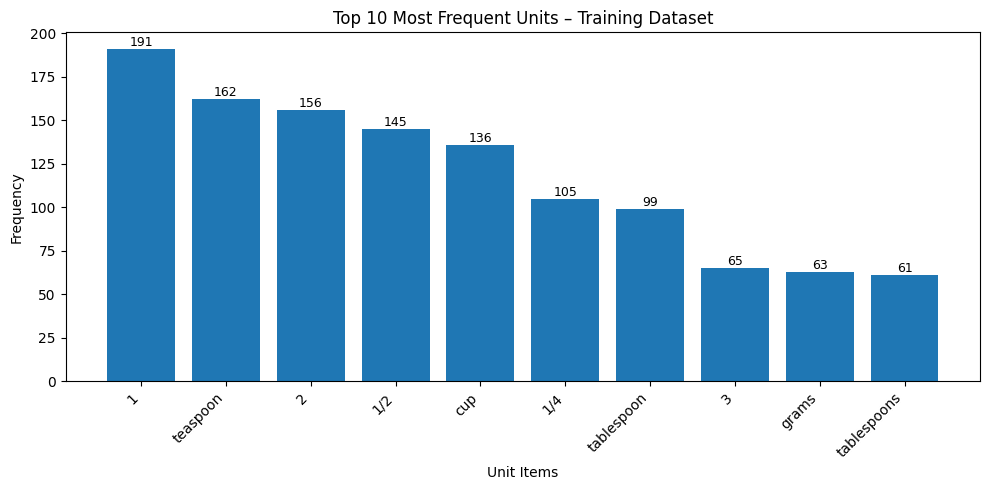

In [311]:
# plot the top frequent units in training data
plot_top_items(top_units, label="Unit", dataset_name="Training")

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [315]:
# define unit and quantity keywords along with quantity pattern
import re

# Unit keywords commonly found in recipes
unit_keywords = {
    "cup", "cups",
    "tbsp", "tablespoon", "tablespoons", "tbsps",
    "tsp", "teaspoon", "teaspoons",
    "gram", "grams", "g",
    "kg", "kilogram", "kilograms",
    "mg", "milligram", "milligrams",
    "ml", "milliliter", "milliliters",
    "l", "liter", "litre", "liters", "litres",
    "oz", "ounce", "ounces",
    "lb", "lbs", "pound", "pounds",
    "pinch", "pinches",
    "dash", "dashes",
    "clove", "cloves",
    "slice", "slices",
    "can", "cans",
    "packet", "packets",
    "package", "packages",
    "stick", "sticks",
    "piece", "pieces",
    "bunch", "bunches"
}

# Quantity keywords used in recipes
quantity_keywords = {
    "half", "quarter", "third",
    "one", "two", "three", "four", "five", "six",
    "seven", "eight", "nine", "ten",
    "dozen",
    "few", "several", "couple"
}

# Unicode fraction symbols commonly found
unicode_fractions = "¼|½|¾|⅐|⅑|⅒|⅓|⅔|⅕|⅖|⅗|⅘|⅙|⅚|⅛|⅜|⅝|⅞"

# Quantity regex pattern:
# matches integers, decimals, fractions, mixed numbers, unicode fractions
quantity_pattern = re.compile(
    rf"""^(
        (\d+(\.\d+)?) |            # integer or decimal -> 1, 1.5
        (\d+[\s-]+\d+/\d+) |      # mixed fraction -> 1 1/2 or 1-1/2
        (\d+/\d+) |               # simple fraction -> 1/2
        ({unicode_fractions})     # unicode fraction -> ½, ¼
    )$""",
    re.VERBOSE
)

In [317]:
# load spaCy model
import spacy

try:
    # Try loading the small English model
    nlp = spacy.load("en_core_web_sm")
    print("Loaded spaCy model: en_core_web_sm")

except Exception as e:
    print("spaCy model 'en_core_web_sm' not found. Falling back to blank English model.")
    
    # Fallback tokenizer-only model (no POS, no NER)
    nlp = spacy.blank("en")

nlp  # returns the loaded spaCy pipeline

Loaded spaCy model: en_core_web_sm


In [318]:
doc = nlp("1 1/2 cups of sugar")
[t.text for t in doc]

['1', '1/2', 'cups', 'of', 'sugar']

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [323]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions
_fraction_re = re.compile(r'^\d+/\d+$')
_decimal_re = re.compile(r'^\d+\.\d+$')
_mixed_re = re.compile(r'^\d+[\s-]+\d+/\d+$')

def is_fraction_text(s: str) -> bool:
    s = s.strip()
    return bool(_fraction_re.match(s) or _mixed_re.match(s) or re.search(unicode_fractions, s))

def is_decimal_text(s: str) -> bool:
    return bool(_decimal_re.match(s))

def matches_quantity_pattern(s: str) -> bool:
    return bool(quantity_pattern.match(s.strip()))

def is_unit_text(s: str) -> bool:
    return s.lower() in unit_keywords

def is_quantity_keyword_text(s: str) -> bool:
    return s.lower() in quantity_keywords

# Process the entire sentence with spaCy
# main function
def word2features(sent, i):
    """
    sent: spaCy Doc or list of spaCy Token objects OR a raw string (will be processed by nlp)
    i: index of token in sent
    returns: dict of features for token at position i
    """
    # require nlp to be available
    try:
        nlp  # noqa: F821
    except NameError:
        raise RuntimeError("spaCy pipeline 'nlp' not found. Load spaCy (e.g., nlp = spacy.load('en_core_web_sm')) before calling this function.")

    # if user passed a raw string, process it
    if isinstance(sent, str):
        doc = nlp(sent)
        tokens = list(doc)
    else:
        tokens = list(sent)  # assume spaCy tokens or strings

    # ensure i is valid
    if not (0 <= i < len(tokens)):
        raise IndexError("Index i out of range for sentence tokens.")

    # pick token object or string text
    use_spacy_token = hasattr(tokens[0], "text")
    tok = tokens[i]
    text = tok.text if use_spacy_token else str(tok)
    lower = text.lower()

    # --- Core Features ---
    features = {
        "bias": 1.0,
        "token": lower,
        "shape": tok.shape_ if use_spacy_token else ("X" if any(c.isalpha() for c in text) else text),
        "is_stop": tok.is_stop if use_spacy_token else False,
        "is_digit": tok.is_digit if use_spacy_token else text.isdigit(),
        "has_digit": any(ch.isdigit() for ch in text),
        "has_alpha": any(ch.isalpha() for ch in text),
        "hyphenated": "-" in text,
        "slash_present": "/" in text,
        "is_title": text.istitle(),
        "is_upper": text.isupper(),
        "is_punct": tok.is_punct if use_spacy_token else (len(text) == 1 and not text.isalnum()),
    }

    # POS/lemma/tag/dep when spaCy available; fallback placeholders otherwise
    if use_spacy_token:
        features.update({
            "lemma": tok.lemma_.lower(),
            "pos_tag": tok.pos_,
            "tag": tok.tag_,
            "dep": tok.dep_,
        })
    else:
        features.update({
            "lemma": lower,
            "pos_tag": "X",
            "tag": "X",
            "dep": "X",
        })

    # --- Improved Quantity & Unit Detection ---
    fq_is_quantity_kw = is_quantity_keyword_text(lower)
    fq_is_unit_kw = is_unit_text(lower)
    fq_matches_qpat = matches_quantity_pattern(lower)
    fq_is_fraction = is_fraction_text(lower)
    fq_is_decimal = is_decimal_text(lower)
    # spaCy tokens have .like_num boolean which is robust for numbers; fallback to pattern checks
    if use_spacy_token:
        like_num = tok.like_num
    else:
        like_num = bool(lower.isdigit() or fq_is_decimal or fq_is_fraction or fq_matches_qpat)

    features.update({
        "is_quantity": bool(fq_is_quantity_kw or fq_matches_qpat or like_num),
        "is_unit": bool(fq_is_unit_kw),
        "is_numeric": bool(like_num),
        "is_fraction": bool(fq_is_fraction),
        "is_decimal": bool(fq_is_decimal),
    })

    # --- Contextual Features ---
    # preceding token details
    if i > 0:
        prev_tok = tokens[i - 1]
        prev_text = prev_tok.text if use_spacy_token else str(prev_tok)
        prev_lower = prev_text.lower()
        prev_is_quantity = is_quantity_keyword_text(prev_lower) or matches_quantity_pattern(prev_lower) or (prev_tok.like_num if use_spacy_token else any(ch.isdigit() for ch in prev_text))
        prev_is_digit = (prev_tok.like_num if use_spacy_token else prev_text.isdigit())
        features.update({
            "preceding_word": prev_text,
            "prev_token": prev_lower,
            "prev_is_quantity": bool(prev_is_quantity),
            "prev_is_digit": bool(prev_is_digit),
        })
    else:
        features["BOS"] = True
        features.update({
            "preceding_word": "",
            "prev_token": "",
            "prev_is_quantity": False,
            "prev_is_digit": False,
        })

    # following token details
    if i < len(tokens) - 1:
        next_tok = tokens[i + 1]
        next_text = next_tok.text if use_spacy_token else str(next_tok)
        next_lower = next_text.lower()
        next_is_unit = is_unit_text(next_lower)
        next_is_quantity = is_quantity_keyword_text(next_lower) or matches_quantity_pattern(next_lower)
        # next_is_ingredient heuristic: not a unit and not a quantity (weak signal)
        next_is_ingredient = not (next_is_unit or next_is_quantity)
        features.update({
            "following_word": next_text,
            "next_token": next_lower,
            "next_is_unit": bool(next_is_unit),
            "next_is_ingredient": bool(next_is_ingredient),
        })
    else:
        features["EOS"] = True
        features.update({
            "following_word": "",
            "next_token": "",
            "next_is_unit": False,
            "next_is_ingredient": False,
        })

    return features

# Utility: produce features for entire sentence (CRF-ready)
def sent2features(sent):
    if isinstance(sent, str):
        doc = nlp(sent)
        tokens = list(doc)
    else:
        tokens = list(sent)
    return [word2features(tokens, i) for i in range(len(tokens))]


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [327]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    """
    Generate CRF feature dictionaries for every token in a sentence.
    Accepts:
      - sent: spaCy Doc, list of spaCy Token objects, list of strings, or raw string
    Returns:
      - List[Dict] feature dict for each token, produced by calling word2features(tokens, i)
    """
    # ensure word2features and nlp exist
    try:
        word2features  # noqa: F821
    except NameError:
        raise RuntimeError("word2features not defined. Define word2features(sent, i) before using sent2features.")
    
    # If raw string, process with spaCy to get tokens
    if isinstance(sent, str):
        try:
            doc = nlp(sent)   # nlp should be loaded earlier
            tokens = list(doc)
        except NameError:
            raise RuntimeError("spaCy pipeline 'nlp' not found. Load spaCy or pass tokenized input.")
    else:
        # assume sent is already tokenized (spaCy tokens or plain token list)
        tokens = list(sent)

    # call word2features for each token index
    return [word2features(tokens, i) for i in range(len(tokens))]

In [329]:
def recipes2features(recipes):
    """
    Apply sent2features over a collection of recipe sentences.
    Accepts:
      - recipes: iterable of sentences (each can be a string or token list/doc)
    Returns:
      - List[List[Dict]]: outer list per recipe, inner list of token feature dicts
    """
    all_features = []
    for sent in recipes:
        feats = sent2features(sent)
        all_features.append(feats)
    return all_features

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [333]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
# Convert training sentences into feature dictionaries
X_train_features = [sent2features(sent) for sent in X_train]

# Convert validation sentences into feature dictionaries
X_val_features = [sent2features(sent) for sent in X_val]

print("Number of training sentences processed:", len(X_train_features))
print("Number of validation sentences processed:", len(X_val_features))

Number of training sentences processed: 196
Number of validation sentences processed: 84


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [336]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [list(labels) for labels in y_train]
y_val_labels   = [list(labels) for labels in y_val]

print("Number of training label sequences:", len(y_train_labels))
print("Number of validation label sequences:", len(y_val_labels))

Number of training label sequences: 196
Number of validation label sequences: 84


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [339]:
# print the length of train features and labels
print("Length of X_train_features:", len(X_train_features))
print("Length of y_train_labels:", len(y_train_labels))

Length of X_train_features: 196
Length of y_train_labels: 196


In [341]:
# print the length of validation features and labels
print("Length of X_val_features:", len(X_val_features))
print("Length of y_val_labels:", len(y_val_labels))

Length of X_val_features: 84
Length of y_val_labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [345]:
# Flatten labels in y_train
y_train_flat = [label for sentence_labels in y_train_labels for label in sentence_labels]

print("Total labels after flattening:", len(y_train_flat))

Total labels after flattening: 7114


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [348]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

# Count how many times each label appears in y_train_flat
label_counts = Counter(y_train_flat)

# Total number of label samples in training set
total_samples = sum(label_counts.values())

print("Label Counts:", label_counts)
print("Total Samples:", total_samples)

Label Counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total Samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [351]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {}
for label, count in label_counts.items():
    weight = total_samples / count   # inverse frequency
    weight_dict[label] = weight

In [353]:
# penalise ingredient label
for ing_label in ["B-ING", "I-ING"]:
    if ing_label in weight_dict:
        weight_dict[ing_label] *= 1.2   # apply 20% penalty boost

print("weight_dict:", weight_dict)

weight_dict: {'quantity': 7.259183673469388, 'unit': 8.771886559802713, 'ingredient': 1.336464399774563}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [356]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    X : list of input recipe sentences
    y : list of label sequences corresponding to X
    weight_dict : dict containing class weights (inverse frequency)

    Returns:
        feature_list_all : list of feature dicts per token per sentence
        weight_list_all  : list of weights aligned with each token label
    """

    feature_list_all = []
    weight_list_all = []

    # Loop through all sentences and their labels
    for sent, labels in zip(X, y):

        # Extract token-level features for the sentence
        sent_features = sent2features(sent)
        feature_list_all.append(sent_features)

        # Apply class weights to each token label inside the sentence
        sent_weights = [weight_dict[label] for label in labels]
        weight_list_all.append(sent_weights)

    return feature_list_all, weight_list_all

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [359]:
# Apply manually computed class weights

# Extract weighted features for training dataset
X_train_weighted_features, y_train_token_weights = extract_features_with_class_weights(
    X_train, 
    y_train_labels, 
    weight_dict
)

# Extract weighted features for validation dataset
X_val_weighted_features, y_val_token_weights = extract_features_with_class_weights(
    X_val, 
    y_val_labels, 
    weight_dict
)

print("Weighted Training Sentences:", len(X_train_weighted_features))
print("Weighted Validation Sentences:", len(X_val_weighted_features))

Weighted Training Sentences: 196
Weighted Validation Sentences: 84


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [365]:
# initialise CRF model with the specified hyperparameters and use weight_dict
import sklearn_crfsuite

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# train the CRF model with the weighted training data
crf.fit(
    X_train_weighted_features, 
    y_train_labels,
)

print("CRF model training completed.")

CRF model training completed.


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [367]:
# evaluate on the training dataset
y_pred_train = crf.predict(X_train_weighted_features)

In [371]:
# specify the flat classification report by using training data for evaluation
from sklearn.metrics import classification_report, confusion_matrix

y_train_true_flat = [label for sent in y_train_labels for label in sent]
y_train_pred_flat = [label for sent in y_pred_train for label in sent]

labels_sorted = sorted(crf.classes_)

print("Classification Report (Training Data):\n")
print(classification_report(
    y_train_true_flat,
    y_train_pred_flat,
    labels=labels_sorted,
    zero_division=0
))

Classification Report (Training Data):

              precision    recall  f1-score   support

  ingredient       0.99      1.00      0.99      5323
    quantity       1.00      0.98      0.99       980
        unit       0.98      0.96      0.97       811

    accuracy                           0.99      7114
   macro avg       0.99      0.98      0.98      7114
weighted avg       0.99      0.99      0.99      7114



In [373]:
# create a confusion matrix on training datset
cm_train = confusion_matrix(
    y_train_true_flat,
    y_train_pred_flat,
    labels=labels_sorted
)

cm_train_df = pd.DataFrame(cm_train, index=labels_sorted, columns=labels_sorted)
print("Confusion Matrix (Training Data):\n")
display(cm_train_df)

Confusion Matrix (Training Data):



,ingredient,quantity,unit
ingredient,5307,2,14
quantity,19,961,0
unit,32,0,779


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [375]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf, "crf_model.pkl")

print("CRF model saved successfully as crf_model.pkl")

CRF model saved successfully as crf_model.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [377]:
# predict the crf model on validation dataset
y_pred_val = crf.predict(X_val_weighted_features)

In [383]:
# specify flat classification report
y_val_true_flat = [label for sent in y_val_labels for label in sent]
y_val_pred_flat = [label for sent in y_pred_val for label in sent]

labels_sorted = sorted(crf.classes_)

print("Classification Report (Validation Data):\n")
print(classification_report(
    y_val_true_flat,
    y_val_pred_flat,
    labels=labels_sorted,
    zero_division=0
))

Classification Report (Validation Data):

              precision    recall  f1-score   support

  ingredient       0.98      0.99      0.99      2107
    quantity       0.99      0.99      0.99       411
        unit       0.96      0.91      0.93       358

    accuracy                           0.98      2876
   macro avg       0.98      0.96      0.97      2876
weighted avg       0.98      0.98      0.98      2876



In [385]:
# create a confusion matrix on validation dataset
cm_val = confusion_matrix(
    y_val_true_flat,
    y_val_pred_flat,
    labels=labels_sorted
)

cm_val_df = pd.DataFrame(cm_val, index=labels_sorted, columns=labels_sorted)
print("Confusion Matrix (Validation Data):\n")
display(cm_val_df)

Confusion Matrix (Validation Data):



,ingredient,quantity,unit
ingredient,2094,3,10
quantity,4,405,2
unit,34,0,324


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [387]:
# sanity check: lengths should match
assert len(y_val_true_flat) == len(y_val_pred_flat), "Flattened true and predicted label lengths do not match!"

In [389]:
# flatten Labels and Initialise Error Data
error_data = []

# dataframe scaffold with useful columns for analysis
error_df = pd.DataFrame(
    columns=[
        "sent_idx",      # sentence index in X_val
        "token_idx",     # token index within sentence
        "token_text",    # token text (if available)
        "true_label",    # gold label
        "pred_label",    # predicted label
        "prev_token",    # previous token text
        "next_token",    # next token text
        "sentence_text"  # entire sentence (optional)
    ]
)

# Precompute indices of mismatches 
mismatch_indices = [i for i, (t, p) in enumerate(zip(y_val_true_flat, y_val_pred_flat)) if t != p]

print("Flattened validation labels length:", len(y_val_true_flat))
print("Number of mismatches (tokens):", len(mismatch_indices))
print("Initialized error_data (list) and empty error_df (DataFrame) for storing misclassifications.")

Flattened validation labels length: 2876
Number of mismatches (tokens): 53
Initialized error_data (list) and empty error_df (DataFrame) for storing misclassifications.


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [391]:
# iterate and collect Error Information
error_data = []
try:
    y_pred_val
except NameError:
    y_pred_val = crf.predict(X_val_weighted_features)

def _tok_text(t):
    return t.text if hasattr(t, "text") else str(t)

for sent_idx, (x_sent, true_labels, pred_labels) in enumerate(zip(X_val, y_val_labels, y_pred_val)):
    # ensure we have a list of token texts
    if isinstance(x_sent, str):
        doc = nlp(x_sent)
        tokens = list(doc)
    else:
        tokens = list(x_sent)
    token_texts = [_tok_text(t) for t in tokens]

    # align lengths (truncate to shortest to avoid index errors)
    L = min(len(token_texts), len(true_labels), len(pred_labels))

    for tok_idx in range(L):
        true_lbl = true_labels[tok_idx]
        pred_lbl = pred_labels[tok_idx]
        if true_lbl == pred_lbl:
            continue

        token_str = token_texts[tok_idx]

        # get previous and next tokens with handling for boundary cases
        if tok_idx > 0:
            prev_token = token_texts[tok_idx - 1]
        else:
            prev_token = ""   # BOS

        if tok_idx < L - 1:
            next_token = token_texts[tok_idx + 1]
        else:
            next_token = ""   # EOS

        error_data.append({
            "sent_idx": sent_idx,
            "token_idx": tok_idx,
            "token_text": token_str,
            "true_label": true_lbl,
            "pred_label": pred_lbl,
            "prev_token": prev_token,
            "next_token": next_token
        })

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [393]:
# Create DataFrame and Print Overall Accuracy
from sklearn.metrics import accuracy_score

# Convert error_data (list of dicts) into a DataFrame
error_df = pd.DataFrame(error_data)

print("Error DataFrame:")
display(error_df.head())

# Compute overall accuracy on validation set
y_val_true_flat = [label for sent in y_val_labels for label in sent]
y_val_pred_flat = [label for sent in y_pred_val for label in sent]

overall_accuracy = accuracy_score(y_val_true_flat, y_val_pred_flat)

print("\nOverall Accuracy on Validation Data:", overall_accuracy)

Error DataFrame:


,sent_idx,token_idx,token_text,true_label,pred_label,prev_token,next_token
0,2,34,few,ingredient,quantity,Leaves,
1,5,18,cloves,ingredient,unit,3,garlic
2,5,21,Spoon,unit,ingredient,big,oil
3,6,7,cloves,unit,ingredient,seeds,garlic
4,6,35,pieces,ingredient,unit,small,1/4



Overall Accuracy on Validation Data: 0.9815716272600834


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [401]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

# Flatten true & predicted labels
y_val_true_flat = [lbl for sent in y_val_labels for lbl in sent]
y_val_pred_flat = [lbl for sent in y_pred_val for lbl in sent]

# Sorted labels
labels_sorted = sorted(crf.classes_)

# Confusion matrix
cm = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels_sorted)
cm_df = pd.DataFrame(cm, index=labels_sorted, columns=labels_sorted)

# Per-label values
total_per_label = cm.sum(axis=1)
correct_per_label = cm.diagonal()
errors_per_label = total_per_label - correct_per_label

# Accuracy per label 
accuracy_per_label = correct_per_label / total_per_label
accuracy_per_label = np.nan_to_num(accuracy_per_label, nan=0.0)

# class weights
weights = {lbl: weight_dict.get(lbl, 1.0) for lbl in labels_sorted}

# Summary DF
summary_df = pd.DataFrame({
    "label": labels_sorted,
    "total": total_per_label,
    "errors": errors_per_label,
    "accuracy": accuracy_per_label,
    "class_weight": [weights[lbl] for lbl in labels_sorted]
}).set_index("label")

print("Per-label error summary (validation):")
display(summary_df)

Per-label error summary (validation):


,total,errors,accuracy,class_weight
label,,,,
ingredient,2107,13,0.993830,1.336464
quantity,411,6,0.985401,7.259184
unit,358,34,0.905028,8.771887


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

The CRF model performs strongly on the validation dataset with an overall token-level accuracy of 98.16%. The classification report and confusion matrix highlight a high level of consistency across all three entity types: ingredient, quantity, and unit, with especially strong performance on high-support classes.

1. Ingredient Labels

    - Highest accuracy: 99.38%

    - Very few mistakes (13 out of 2107 tokens).

    - Most ingredient errors involve tokens like "cloves" or "pieces" incorrectly predicted as unit due to their dual semantic usage in cooking contexts (e.g., “3 cloves garlic”).

    - Since "cloves" and "pieces" frequently behave like units in natural language, misclassification is understandable.

2. Quantity Labels

    - Accuracy of 98.54%.

    - Errors mostly occur when the model confuses quantity tokens such as “few” or “3” with ingredient or unit labels, especially when the surrounding context is ambiguous.

    - Example: “few Leaves” → “few” predicted as quantity instead of ingredient due to misleading context structure.

3. Unit Labels

    - Lowest accuracy: 90.50%

    - Units account for 34 of the 53 total errors, making them the weakest component.

    - Units like “spoon”, “cloves”, “pieces” are often confused with ingredient labels.

    - These errors typically occur when:

    - The unit is not part of the predefined unit_keywords.

    - The unit token looks like a noun that could also be an ingredient.

    - The model lacks contextual cues from noisy or incomplete sentences.

4. General Misclassification Patterns

    - Ingredient ↔ Unit swaps are the most common type of error (especially for multi-use nouns).

    - Tokens with weak preceding quantities (e.g., “big oil”, “seeds garlic”) cause confusion.

    - Some tokens like “few”, categorized as quantity keywords, are labeled as ingredients depending on the dataset annotation rules.

    - Sentences with irregular formatting or missing delimiters increase error frequency.

5. Class Weight Impact

    - Unit class had the highest class weight (~8.77), reflecting its rarity and helping the model learn better.

    - Despite high weight, the model still finds unit detection challenging, suggesting:

    - Need for broader unit keyword list.

    - Additional features for noun-based units.

    - Possibly richer context windows or dependency-based features.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.

The CRF model demonstrates strong performance on the validation dataset with an overall accuracy of 98%, effectively identifying ingredient, quantity, and unit entities. Most errors arise from ambiguous tokens such as cloves, pieces, and spoon, which can function as both units and ingredients depending on context. Unit detection remains the weakest category, suggesting the need for an expanded unit vocabulary and richer contextual features. Overall, the model generalizes well and provides reliable entity extraction for recipe text.